# Detaillierte Analyse im Bezug auf gesellschaftliche Abstimmungen

## Importiere notwendige Bibliotheken

In [201]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## Datensatz vorbereiten

In [202]:
# Lade den Datensatz
df = pd.read_csv('./data/dataset.csv', sep=';', low_memory=False)

# Konvertiere Datumsspalte in datetime-Format
df['datum'] = pd.to_datetime(df['datum'], format='%d.%m.%Y', errors='coerce')
df['year'] = df['datum'].dt.year

## Extraktion von gesellschaftlich Orientierten Abstimmungen

In [203]:

# Definiere Schlüsselwörter für gesellschaftsorientierte Abstimmungen
social_keywords = [
    'gesellschaft', 'sozial', 'frauen', 'ehe', 'familie', 'bildung', 'gesundheit', 
    'migration', 'ausländer', 'gleichstellung', 'religion', 'kultur', 'abtreibung',
    'schwangerschaft', 'sexualität', 'homosexualität', 'gender', 'sprache', 'identität',
    'integration', 'minderheit', 'diskriminierung', 'rassismus', 'menschenrecht',
    'sterbehilfe', 'adoption', 'elternzeit', 'mutterschaft', 'vaterschaft'
]

# Erstelle eine Funktion zur Identifizierung gesellschaftsorientierter Abstimmungen
def is_society_oriented(row):
    # Kombiniere relevante Textspalten für die Suche
    text = ' '.join([
        str(row.get('titel_kurz_d', '')).lower(),
        str(row.get('titel_off_d', '')).lower(),
        str(row.get('text_d', '')).lower()
    ])
    return any(keyword in text for keyword in social_keywords)

# Identifiziere gesellschaftsorientierte Abstimmungen
df['society_oriented'] = df.apply(is_society_oriented, axis=1)

# Extrahiere nur gesellschaftsorientierte Abstimmungen
society_votes = df[df['society_oriented'] == True].copy()

# Speichere als CSV mit gleicher Struktur wie das Original
society_votes.to_csv('./data/gesellschaftliche_abstimmungen.csv', sep=';', index=False)

print(f"Extrahiert: {len(society_votes)} gesellschaftsorientierte Abstimmungen von insgesamt {len(df)} Abstimmungen")
print(f"Prozentsatz: {len(society_votes)/len(df)*100:.2f}%")

Extrahiert: 82 gesellschaftsorientierte Abstimmungen von insgesamt 696 Abstimmungen
Prozentsatz: 11.78%


## Ranking der Kantone nach Liberalität/Konservativität

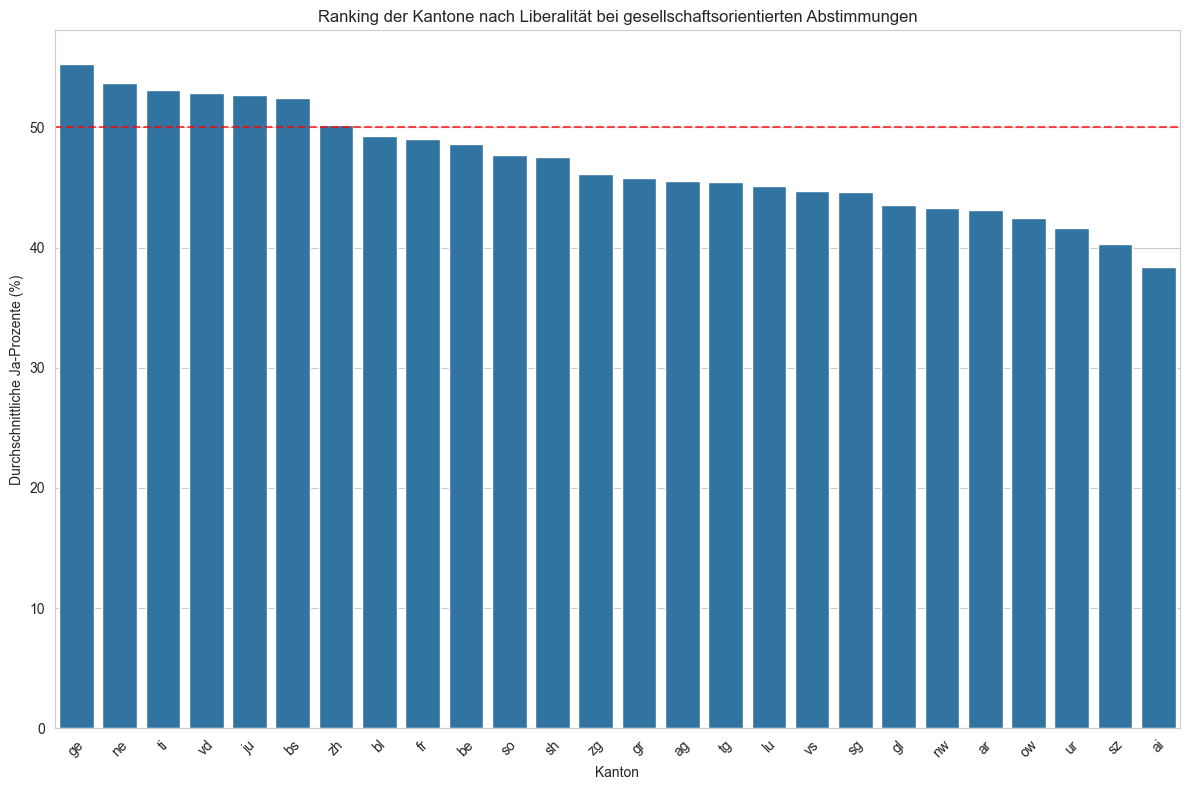

Ranking der Kantone nach Liberalität (höhere Ja-Prozente = liberaler):


,Kanton,Durchschnittliche_Ja_Prozente
24,ge,55.304568
23,ne,53.669259
20,ti,53.148148
21,vd,52.862963
25,ju,52.724444
11,bs,52.479630
0,zh,50.189506
12,bl,49.271481
9,fr,49.006420
1,be,48.580617


In [204]:
# Lade die extrahierten gesellschaftsorientierten Abstimmungen
society_votes = pd.read_csv('./data/gesellschaftliche_abstimmungen.csv', sep=';', low_memory=False)

# Identifiziere alle Kantonsspalten (Format: 'kanton-japroz')
canton_cols = [col for col in society_votes.columns if col.endswith('-japroz')]
cantons = [col.split('-')[0] for col in canton_cols]

# Konvertiere alle kantonalen Ja-Prozent-Spalten zu numerischen Werten
for col in canton_cols:
    society_votes[col] = pd.to_numeric(society_votes[col], errors='coerce')

# Berechne durchschnittliche Ja-Prozente pro Kanton über alle gesellschaftsorientierten Abstimmungen
canton_means = {}
for canton, col in zip(cantons, canton_cols):
    canton_means[canton] = society_votes[col].mean()

# Erstelle ein DataFrame für das Ranking
canton_ranking = pd.DataFrame({
    'Kanton': cantons,
    'Durchschnittliche_Ja_Prozente': [canton_means[canton] for canton in cantons]
})

# Sortiere nach Ja-Prozenten (absteigend für liberalste zuerst)
canton_ranking = canton_ranking.sort_values('Durchschnittliche_Ja_Prozente', ascending=False)

# Visualisiere das Ranking
plt.figure(figsize=(12, 8))
sns.barplot(data=canton_ranking, x='Kanton', y='Durchschnittliche_Ja_Prozente')
plt.title('Ranking der Kantone nach Liberalität bei gesellschaftsorientierten Abstimmungen')
plt.xlabel('Kanton')
plt.ylabel('Durchschnittliche Ja-Prozente (%)')
plt.xticks(rotation=45)
plt.axhline(y=50, color='r', linestyle='--', alpha=0.7)  # 50% Schwellenlinie
plt.tight_layout()
plt.show()

# Zeige das Ranking als Tabelle
print("Ranking der Kantone nach Liberalität (höhere Ja-Prozente = liberaler):")
display(canton_ranking)

## Datum Standardisieren

In [205]:
# Lade die extrahierten gesellschaftsorientierten Abstimmungen
society_votes = pd.read_csv('./data/gesellschaftliche_abstimmungen.csv', sep=';', low_memory=False)

# Format ist YYYY-MM-DD
society_votes['datum'] = pd.to_datetime(society_votes['datum'], format='%Y-%m-%d', errors='coerce')

# Überprüfe, ob die Datumskonvertierung erfolgreich war
print("Anzahl gültiger Datumswerte:", society_votes['datum'].notna().sum())
print("Anzahl fehlender Datumswerte:", society_votes['datum'].isna().sum())


society_votes['year'] = society_votes['datum'].dt.year
print("Anzahl gültiger Datumswerte:", society_votes['datum'].notna().sum())

# Überprüfe, ob die Jahreswerte sinnvoll sind
year_range = society_votes['year'].dropna()
if not year_range.empty:
    print(f"Jahresbereich: {year_range.min()} bis {year_range.max()}")

Anzahl gültiger Datumswerte: 82
Anzahl fehlender Datumswerte: 0
Anzahl gültiger Datumswerte: 82
Jahresbereich: 1866 bis 2024


## Unterteilung in Perioden

In [206]:
# Definiere Zeitperioden für die Analyse nur für Zeilen mit gültigen Jahren
society_votes['period'] = None  # Initialisiere mit None
mask = society_votes['year'].notna()
if mask.any():
    try:
        society_votes.loc[mask, 'period'] = pd.cut(
            society_votes.loc[mask, 'year'],
            bins=[1800, 1950, 1980, 2000, 2025],
            labels=['bis 1950', '1951-1980', '1981-2000', '2001-heute']
        )
    except Exception as e:
        print(f"Fehler bei der Erstellung der Perioden: {e}")
        # Alternative: Manuelle Zuweisung der Perioden
        def assign_period(year):
            if pd.isna(year):
                return None
            elif year <= 1950:
                return 'bis 1950'
            elif year <= 1980:
                return '1951-1980'
            elif year <= 2000:
                return '1981-2000'
            else:
                return '2001-heute'

        society_votes['period'] = society_votes['year'].apply(assign_period)

# Überprüfe die Periodenverteilung
print("Verteilung der Perioden:")
print(society_votes['period'].value_counts(dropna=False))

Verteilung der Perioden:
period
2001-heute    31
1981-2000     24
1951-1980     17
bis 1950      10
Name: count, dtype: int64


## Identifizierung für die Ja-Werte

In [207]:
  # Identifiziere die Spalten für kantonale Ja-Prozente
canton_japroz_cols = [col for col in society_votes.columns if col.endswith('-japroz')]
cantons = [col.split('-')[0] for col in canton_japroz_cols]
print(f"Gefundene Kantone: {len(cantons)}")
print(f"Beispiel-Kantone: {cantons[:5] if len(cantons) >= 5 else cantons}")

# Konvertiere alle kantonalen Ja-Prozent-Spalten zu numerischen Werten
for col in canton_japroz_cols:
    society_votes[col] = pd.to_numeric(society_votes[col], errors='coerce')

# Überprüfe, ob Daten in den Ja-Prozent-Spalten vorhanden sind
data_available = {col: society_votes[col].notna().sum() for col in canton_japroz_cols}
print("Anzahl der verfügbaren Datenpunkte pro Kanton:")
for col, count in data_available.items():
    if count > 0:
        print(f"{col}: {count} Datenpunkte")

Gefundene Kantone: 26
Beispiel-Kantone: ['zh', 'be', 'lu', 'ur', 'sz']
Anzahl der verfügbaren Datenpunkte pro Kanton:
zh-japroz: 81 Datenpunkte
be-japroz: 81 Datenpunkte
lu-japroz: 81 Datenpunkte
ur-japroz: 81 Datenpunkte
sz-japroz: 81 Datenpunkte
ow-japroz: 81 Datenpunkte
nw-japroz: 81 Datenpunkte
gl-japroz: 81 Datenpunkte
zg-japroz: 81 Datenpunkte
fr-japroz: 81 Datenpunkte
so-japroz: 81 Datenpunkte
bs-japroz: 81 Datenpunkte
bl-japroz: 81 Datenpunkte
sh-japroz: 81 Datenpunkte
ar-japroz: 81 Datenpunkte
ai-japroz: 81 Datenpunkte
sg-japroz: 81 Datenpunkte
gr-japroz: 81 Datenpunkte
ag-japroz: 81 Datenpunkte
tg-japroz: 81 Datenpunkte
ti-japroz: 81 Datenpunkte
vd-japroz: 81 Datenpunkte
vs-japroz: 81 Datenpunkte
ne-japroz: 81 Datenpunkte
ge-japroz: 81 Datenpunkte
ju-japroz: 54 Datenpunkte


## Analyse der Veränderungen in den Kantonen über die Zeit

### Veränderung über die Zeit

In [208]:
# Berechne die Veränderung für jeden Kanton über die Zeit
canton_changes = {}
for canton in cantons:
    col = f'{canton}-japroz'

    # Überprüfe, ob genügend Daten für diesen Kanton vorhanden sind
    if society_votes[col].notna().sum() < 10:  # Mindestens 10 Datenpunkte erforderlich
        print(f"Zu wenige Daten für Kanton {canton}: {society_votes[col].notna().sum()} Datenpunkte")
        continue

    # Berechne den Mittelwert pro Zeitperiode
    try:
        # Versuche zuerst mit observed=True (für kategorische Daten)
        period_means = society_votes.groupby('period', observed=True)[col].mean()
    except:
        # Falls das nicht funktioniert, versuche ohne observed Parameter
        try:
            period_means = society_votes.groupby('period')[col].mean()
        except Exception as e:
            print(f"Fehler bei der Gruppierung für Kanton {canton}: {e}")
            continue

    print(f"Mittelwerte für {canton}:")
    print(period_means)

    # Berechne die Gesamtveränderung (neueste minus älteste Periode)
    if len(period_means) >= 2 and not period_means.isna().all():
        # Finde die erste und letzte nicht-NaN Periode
        valid_periods = period_means.dropna()
        if len(valid_periods) >= 2:
            first_valid_idx = valid_periods.index[0]
            last_valid_idx = valid_periods.index[-1]

            print(f"Erste gültige Periode: {first_valid_idx}, Letzte gültige Periode: {last_valid_idx}")
            print(f"Wert erste Periode: {valid_periods[first_valid_idx]}, Wert letzte Periode: {valid_periods[last_valid_idx]}")

            total_change = valid_periods[last_valid_idx] - valid_periods[first_valid_idx]
            canton_changes[canton] = total_change
            print(f"Kanton {canton} hat eine Gesamtveränderung von {total_change:.2f} Prozentpunkten.")
        else:
            print(f"Nicht genügend gültige Perioden für Kanton {canton}")


Mittelwerte für zh:
period
1951-1980     46.421176
1981-2000     47.169167
2001-heute    50.125333
bis 1950      64.037000
Name: zh-japroz, dtype: float64
Erste gültige Periode: 1951-1980, Letzte gültige Periode: bis 1950
Wert erste Periode: 46.421176470588236, Wert letzte Periode: 64.037
Kanton zh hat eine Gesamtveränderung von 17.62 Prozentpunkten.
Mittelwerte für be:
period
1951-1980     45.452941
1981-2000     44.874167
2001-heute    50.755333
bis 1950      56.269000
Name: be-japroz, dtype: float64
Erste gültige Periode: 1951-1980, Letzte gültige Periode: bis 1950
Wert erste Periode: 45.45294117647059, Wert letzte Periode: 56.26899999999999
Kanton be hat eine Gesamtveränderung von 10.82 Prozentpunkten.
Mittelwerte für lu:
period
1951-1980     42.380000
1981-2000     41.379583
2001-heute    48.881667
bis 1950      47.615000
Name: lu-japroz, dtype: float64
Erste gültige Periode: 1951-1980, Letzte gültige Periode: bis 1950
Wert erste Periode: 42.38, Wert letzte Periode: 47.61499999999

### Visualisierung der Veränderung

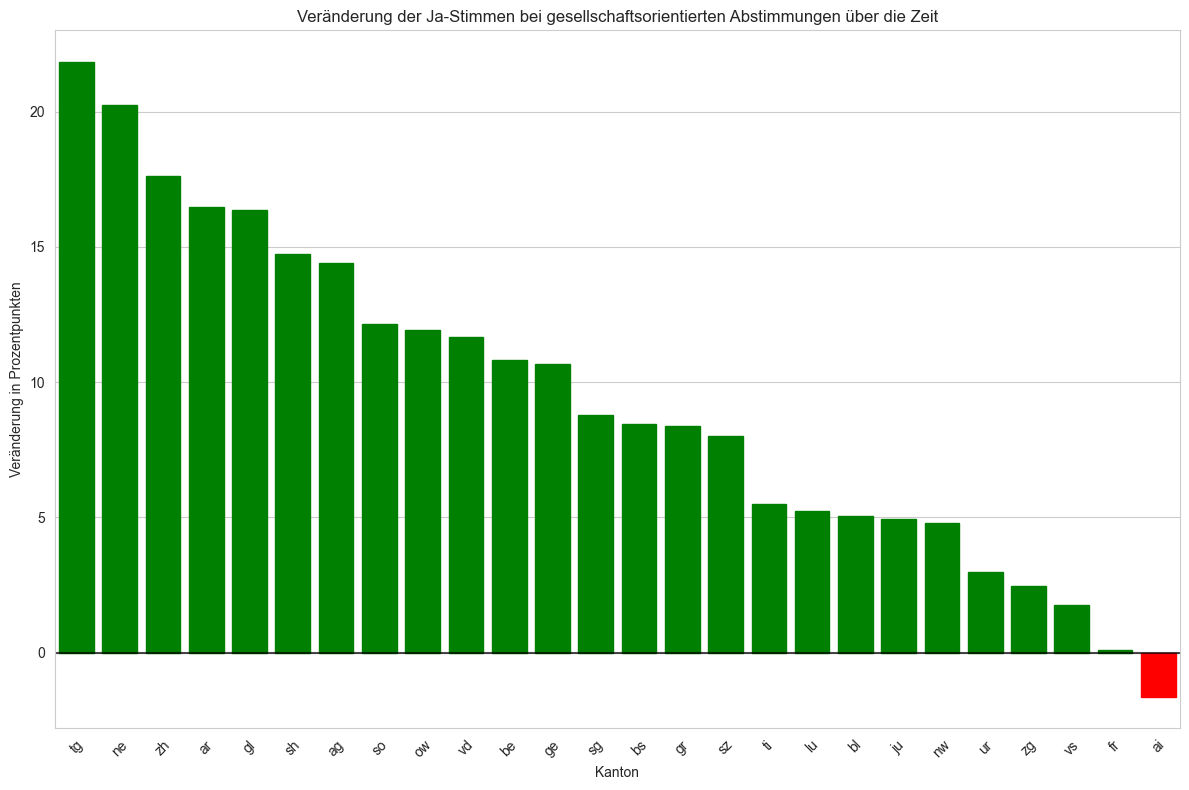

In [209]:
if canton_changes:
    # Erstelle ein DataFrame für die Veränderungen
    change_df = pd.DataFrame({
        'Kanton': list(canton_changes.keys()),
        'Veränderung_Prozentpunkte': list(canton_changes.values())
    })

    # Sortiere nach Veränderung (absteigend)
    change_df = change_df.sort_values('Veränderung_Prozentpunkte', ascending=False)

    # Visualisiere die Veränderungen
    plt.figure(figsize=(12, 8))

    try:
        # Versuche mit dem neueren seaborn API
        bars = sns.barplot(x='Kanton', y='Veränderung_Prozentpunkte', data=change_df)

        # Färbe die Balken je nach positiver oder negativer Veränderung
        for i, bar in enumerate(bars.patches):
            if change_df.iloc[i]['Veränderung_Prozentpunkte'] > 0:
                bar.set_color('green')
            else:
                bar.set_color('red')
    except:
        # Fallback für ältere seaborn Versionen
        try:
            bars = sns.barplot(data=change_df, x='Kanton', y='Veränderung_Prozentpunkte')

            # Färbe die Balken je nach positiver oder negativer Veränderung
            for i, bar in enumerate(bars.patches):
                if change_df.iloc[i]['Veränderung_Prozentpunkte'] > 0:
                    bar.set_color('green')
                else:
                    bar.set_color('red')
        except Exception as e:
            print(f"Fehler bei der Erstellung des Barplots: {e}")
            # Einfacher Fallback ohne Farbcodierung
            plt.bar(change_df['Kanton'], change_df['Veränderung_Prozentpunkte'])

    plt.title('Veränderung der Ja-Stimmen bei gesellschaftsorientierten Abstimmungen über die Zeit')
    plt.xlabel('Kanton')
    plt.ylabel('Veränderung in Prozentpunkten')
    plt.xticks(rotation=45)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.7)
    plt.tight_layout()
    plt.show()

#### Tabellen Ansicht

In [210]:
# Zeige die Veränderungen als Tabelle
print("Veränderung der Kantone über die Zeit (positive Werte = liberaler geworden):")
display(change_df)

Veränderung der Kantone über die Zeit (positive Werte = liberaler geworden):


,Kanton,Veränderung_Prozentpunkte
19,tg,21.828059
23,ne,20.237471
0,zh,17.615824
14,ar,16.476882
7,gl,16.351176
13,sh,14.739941
18,ag,14.385529
10,so,12.131353
5,ow,11.915882
21,vd,11.667471


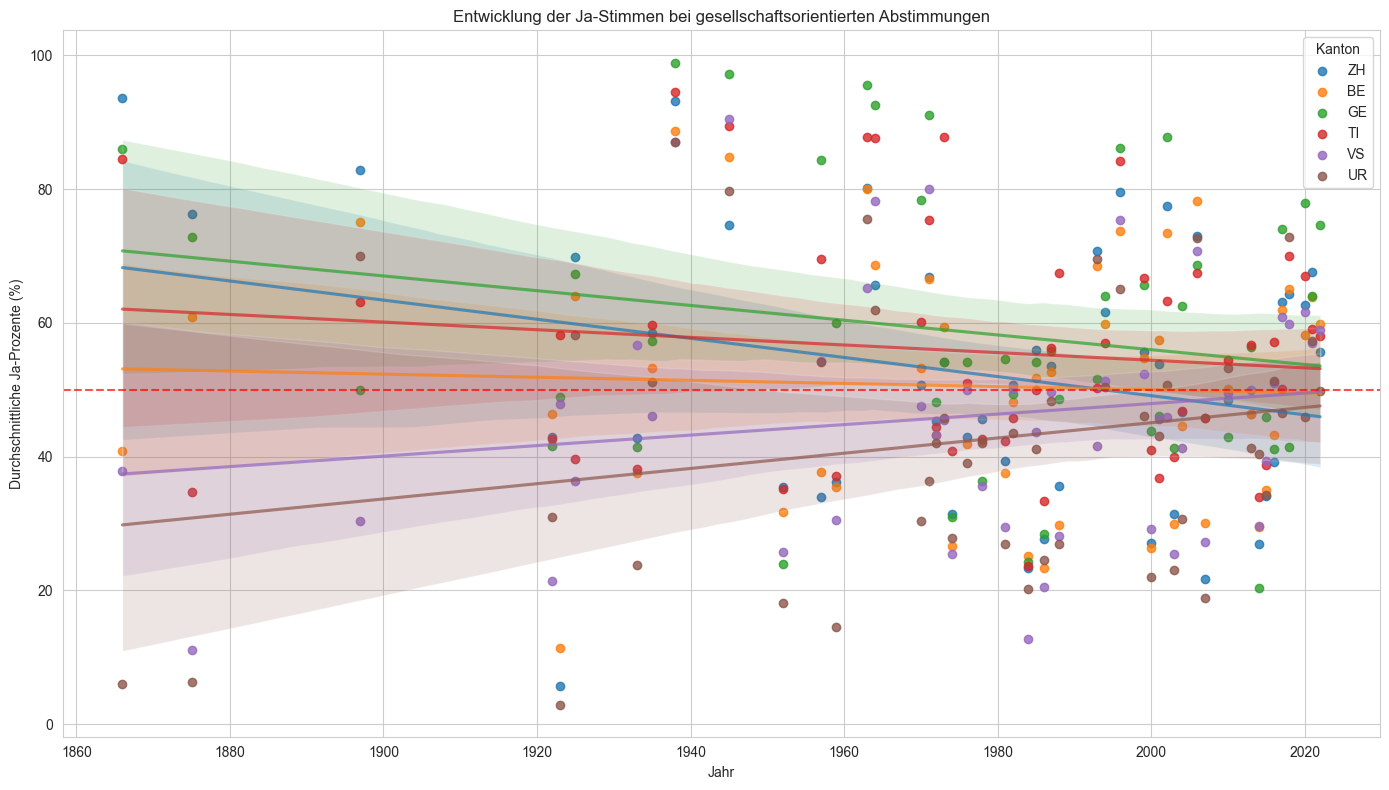

In [211]:
# Detaillierte Analyse der Entwicklung für ausgewählte Kantone
# Wähle Kantone aus, die tatsächlich Daten haben
available_cantons = list(canton_changes.keys())
selected_cantons = ['zh', 'be', 'ge', 'ti', 'vs', 'ur']
selected_cantons = [c for c in selected_cantons if c in available_cantons]

if not selected_cantons:
    # Wenn keiner der bevorzugten Kantone verfügbar ist, nehme die Top-6 mit den größten Veränderungen
    if len(change_df) >= 6:
        selected_cantons = list(change_df['Kanton'].head(3)) + list(change_df['Kanton'].tail(3))
    else:
        selected_cantons = list(change_df['Kanton'])

selected_cols = [f'{canton}-japroz' for canton in selected_cantons]

# Erstelle einen Plot für die Entwicklung über die Zeit
plt.figure(figsize=(14, 8))

for canton, col in zip(selected_cantons, selected_cols):
    # Gruppiere nach Jahr und berechne den Mittelwert
    yearly_data = society_votes.groupby('year')[col].mean().reset_index()
    yearly_data = yearly_data.dropna()  # Entferne Jahre ohne Daten

    if not yearly_data.empty and len(yearly_data) > 1:
        # Plotte die Entwicklung mit Trendlinie
        try:
            sns.regplot(x='year', y=col, data=yearly_data,
                       label=canton.upper(), scatter=True, line_kws={"alpha":0.7})
        except Exception as e:
            print(f"Fehler beim Plotten für Kanton {canton}: {e}")

plt.title('Entwicklung der Ja-Stimmen bei gesellschaftsorientierten Abstimmungen')
plt.xlabel('Jahr')
plt.ylabel('Durchschnittliche Ja-Prozente (%)')
plt.axhline(y=50, color='r', linestyle='--', alpha=0.7)
plt.legend(title='Kanton')
plt.tight_layout()
plt.show()

***Städtische & Ländliche Kantone***

In [212]:
# Zusätzliche Analyse: Vergleich zwischen urbanen und ländlichen Kantonen
urban_cantons = ['zh', 'ge', 'bs', 'vd']  # Städtische Kantone
rural_cantons = ['ur', 'ow', 'nw', 'ai', 'gl']  # Ländliche Kantone

# Filtere auf verfügbare Kantone
available_urban = [c for c in urban_cantons if c in available_cantons]
available_rural = [c for c in rural_cantons if c in available_cantons]

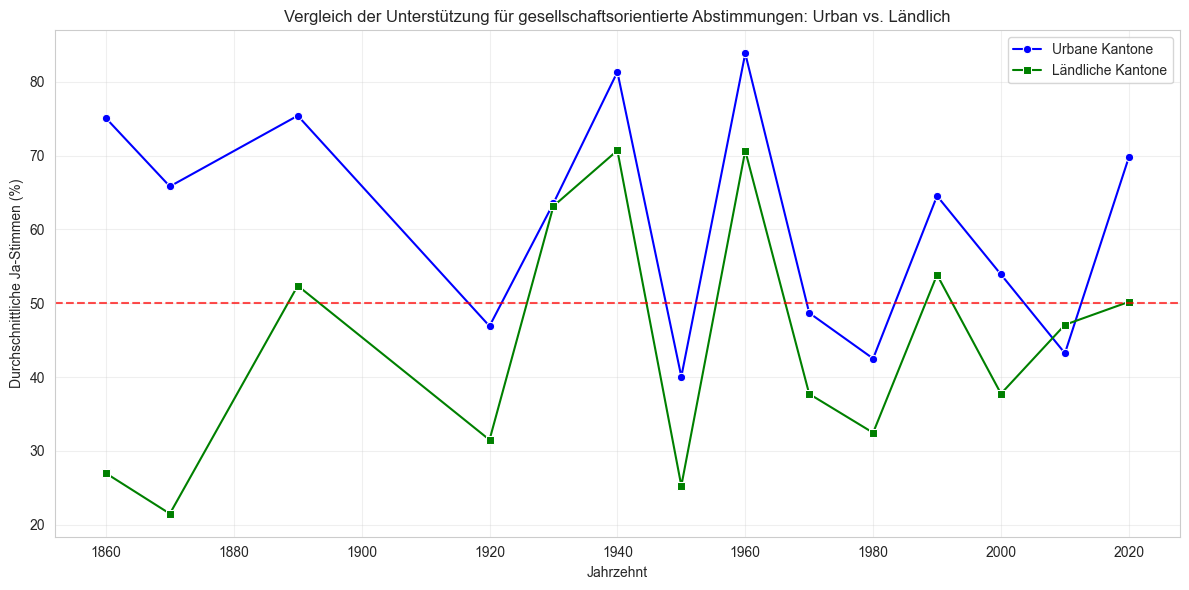

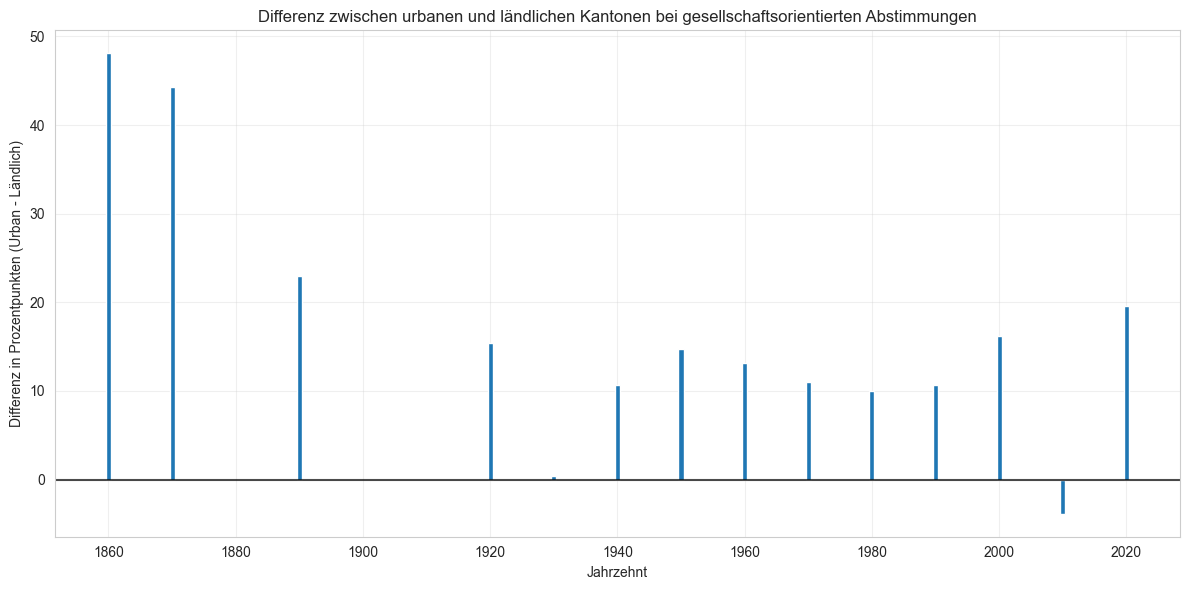

Korrelation zwischen Jahrzehnt und Urban-Rural-Differenz: -0.7041
P-Wert: 0.0049
Es gibt eine statistisch signifikante negative Korrelation zwischen Zeit und Urban-Rural-Differenz.
Dies deutet darauf hin, dass der Unterschied zwischen urbanen und ländlichen Kantonen im Laufe der Zeit abgenommen hat.


In [213]:
if available_urban and available_rural:
    # Berechne durchschnittliche Ja-Prozente für urbane und ländliche Kantone
    society_votes['urban_support'] = society_votes[[f'{c}-japroz' for c in available_urban]].mean(axis=1)
    society_votes['rural_support'] = society_votes[[f'{c}-japroz' for c in available_rural]].mean(axis=1)

    # Gruppiere nach Jahrzehnt für Zeilen mit gültigen Jahren
    mask = society_votes['year'].notna()
    if mask.any():
        society_votes.loc[mask, 'decade'] = (society_votes.loc[mask, 'year'] // 10) * 10

        # Filtere Zeilen mit gültigen Jahrzehnten
        decade_data = society_votes[society_votes['decade'].notna()]

        if not decade_data.empty:
            try:
                urban_rural_by_decade = decade_data.groupby('decade').agg({
                    'urban_support': 'mean',
                    'rural_support': 'mean'
                }).reset_index()

                # Überprüfe, ob genügend Daten für die Visualisierung vorhanden sind
                if not urban_rural_by_decade.empty and urban_rural_by_decade['urban_support'].notna().sum() > 1 and urban_rural_by_decade['rural_support'].notna().sum() > 1:
                    # Visualisiere den Vergleich
                    plt.figure(figsize=(12, 6))

                    # Plotte die Linien für urbane und ländliche Kantone
                    try:
                        sns.lineplot(x='decade', y='urban_support', data=urban_rural_by_decade,
                                    marker='o', label='Urbane Kantone', color='blue')
                        sns.lineplot(x='decade', y='rural_support', data=urban_rural_by_decade,
                                    marker='s', label='Ländliche Kantone', color='green')
                    except Exception as e:
                        print(f"Fehler beim Plotten der Linien: {e}")
                        # Fallback auf einfachere Darstellung
                        plt.plot(urban_rural_by_decade['decade'], urban_rural_by_decade['urban_support'],
                                'o-', label='Urbane Kantone', color='blue')
                        plt.plot(urban_rural_by_decade['decade'], urban_rural_by_decade['rural_support'],
                                's-', label='Ländliche Kantone', color='green')

                    plt.title('Vergleich der Unterstützung für gesellschaftsorientierte Abstimmungen: Urban vs. Ländlich')
                    plt.xlabel('Jahrzehnt')
                    plt.ylabel('Durchschnittliche Ja-Stimmen (%)')
                    plt.axhline(y=50, color='r', linestyle='--', alpha=0.7)
                    plt.legend()
                    plt.grid(True, alpha=0.3)
                    plt.tight_layout()
                    plt.show()

                    # Berechne die Differenz zwischen urbanen und ländlichen Kantonen
                    urban_rural_by_decade['urban_rural_diff'] = urban_rural_by_decade['urban_support'] - urban_rural_by_decade['rural_support']

                    # Visualisiere die Differenz
                    plt.figure(figsize=(12, 6))
                    plt.bar(urban_rural_by_decade['decade'], urban_rural_by_decade['urban_rural_diff'])
                    plt.title('Differenz zwischen urbanen und ländlichen Kantonen bei gesellschaftsorientierten Abstimmungen')
                    plt.xlabel('Jahrzehnt')
                    plt.ylabel('Differenz in Prozentpunkten (Urban - Ländlich)')
                    plt.axhline(y=0, color='black', linestyle='-', alpha=0.7)
                    plt.grid(True, alpha=0.3)
                    plt.tight_layout()
                    plt.show()

                    # Berechne Korrelation zwischen Jahrzehnt und Differenz
                    if len(urban_rural_by_decade) > 2:  # Mindestens 3 Datenpunkte für eine sinnvolle Korrelation
                        correlation, p_value = stats.pearsonr(
                            urban_rural_by_decade['decade'],
                            urban_rural_by_decade['urban_rural_diff']
                        )
                        print(f"Korrelation zwischen Jahrzehnt und Urban-Rural-Differenz: {correlation:.4f}")
                        print(f"P-Wert: {p_value:.4f}")

                        if p_value < 0.05:
                            if correlation > 0:
                                print("Es gibt eine statistisch signifikante positive Korrelation zwischen Zeit und Urban-Rural-Differenz.")
                                print("Dies deutet darauf hin, dass der Unterschied zwischen urbanen und ländlichen Kantonen im Laufe der Zeit zugenommen hat.")
                            else:
                                print("Es gibt eine statistisch signifikante negative Korrelation zwischen Zeit und Urban-Rural-Differenz.")
                                print("Dies deutet darauf hin, dass der Unterschied zwischen urbanen und ländlichen Kantonen im Laufe der Zeit abgenommen hat.")
                        else:
                            print("Es gibt keine statistisch signifikante Korrelation zwischen Zeit und Urban-Rural-Differenz.")
                else:
                    print("Nicht genügend Daten für die Visualisierung des Urban-Rural-Vergleichs.")
            except Exception as e:
                print(f"Fehler bei der Analyse des Urban-Rural-Vergleichs: {e}")
        else:
            print("Keine gültigen Jahrzehntdaten verfügbar.")
    else:
        print("Keine gültigen Jahresdaten für die Jahrzehntanalyse verfügbar.")
else:
    print("Nicht genügend urbane oder ländliche Kantone verfügbar für den Vergleich.")

### Abschliessende Analyse

In [214]:
# Abschliessende Zusammenfassung
print("\n--- Zusammenfassung der Analyse ---")
if 'change_df' in locals() and not change_df.empty:
    avg_change = change_df['Veränderung_Prozentpunkte'].mean()
    print(f"Durchschnittliche Veränderung über alle Kantone: {avg_change:.2f} Prozentpunkte")

    positive_changes = change_df[change_df['Veränderung_Prozentpunkte'] > 0]
    negative_changes = change_df[change_df['Veränderung_Prozentpunkte'] < 0]

    print(f"Anzahl Kantone mit positiver Veränderung (liberaler geworden): {len(positive_changes)}")
    print(f"Anzahl Kantone mit negativer Veränderung (konservativer geworden): {len(negative_changes)}")

    if len(positive_changes) > len(negative_changes):
        print("Die Mehrheit der Kantone ist über die Zeit liberaler geworden.")
    elif len(positive_changes) < len(negative_changes):
        print("Die Mehrheit der Kantone ist über die Zeit konservativer geworden.")
    else:
        print("Die Anzahl der liberaler und konservativer gewordenen Kantone ist ausgeglichen.")
else:
    print("Keine ausreichenden Daten für eine Zusammenfassung verfügbar.")


--- Zusammenfassung der Analyse ---
Durchschnittliche Veränderung über alle Kantone: 9.37 Prozentpunkte
Anzahl Kantone mit positiver Veränderung (liberaler geworden): 25
Anzahl Kantone mit negativer Veränderung (konservativer geworden): 1
Die Mehrheit der Kantone ist über die Zeit liberaler geworden.


## Analyse der populärsten gesellschaftlichen Themen

Beispiel für Datumsformat: 1866-01-14
Anzahl gültiger Datumswerte: 82
Anzahl fehlender Datumswerte: 0
Beispiel für Jahre: 0    1866
1    1875
2    1897
3    1922
4    1923
Name: year, dtype: int32
Anzahl gültiger Jahreswerte: 82
Verteilung der Perioden:
period
2001-heute    31
1981-2000     24
1951-1980     17
bis 1950      10
Name: count, dtype: int64
Mittelwerte für zh:
period
bis 1950      64.037000
1951-1980     46.421176
1981-2000     47.169167
2001-heute    50.125333
Name: zh-japroz, dtype: float64
Kanton zh hat eine Gesamtveränderung von -13.91 Prozentpunkten.
Mittelwerte für be:
period
bis 1950      56.269000
1951-1980     45.452941
1981-2000     44.874167
2001-heute    50.755333
Name: be-japroz, dtype: float64
Kanton be hat eine Gesamtveränderung von -5.51 Prozentpunkten.
Mittelwerte für lu:
period
bis 1950      47.615000
1951-1980     42.380000
1981-2000     41.379583
2001-heute    48.881667
Name: lu-japroz, dtype: float64
Kanton lu hat eine Gesamtveränderung von 1.27 Prozent

/var/folders/sc/hk55c1v54g3dff0094vmwkb80000gn/T/ipykernel_8043/3428342063.py:80: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  period_means = society_votes.groupby('period')[col].mean()


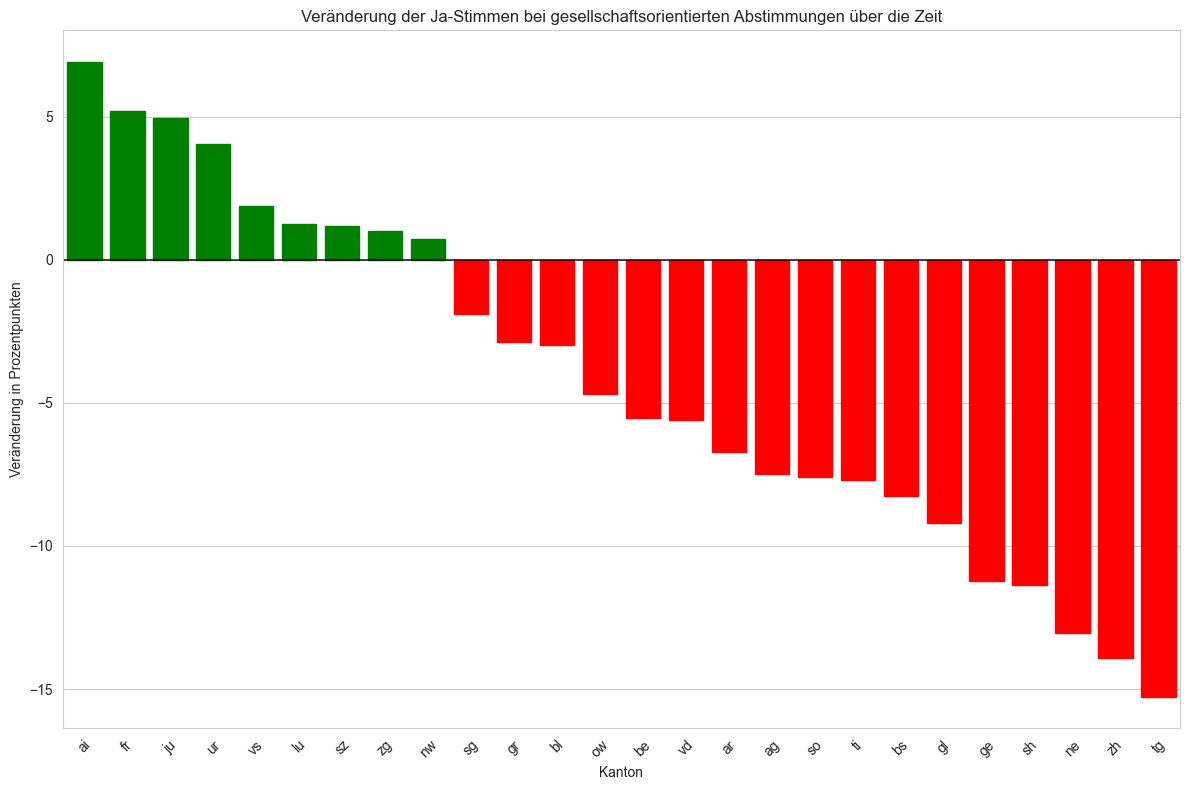

Veränderung der Kantone über die Zeit (positive Werte = liberaler geworden):


,Kanton,Veränderung_Prozentpunkte
15,ai,6.905333
9,fr,5.187667
25,ju,4.943000
3,ur,4.032000
22,vs,1.882667
2,lu,1.266667
4,sz,1.178000
8,zg,0.997667
6,nw,0.743333
16,sg,-1.907667


In [215]:
# Lade die extrahierten gesellschaftsorientierten Abstimmungen
society_votes = pd.read_csv('./data/gesellschaftliche_abstimmungen.csv', sep=';', low_memory=False)

# Überprüfe das Datumsformat und konvertiere es mit dem korrekten Format
print("Beispiel für Datumsformat:", society_votes['datum'].iloc[0] if not society_votes.empty else "Keine Daten")

# Versuche das korrekte Format zu erkennen und zu konvertieren
if '-' in str(society_votes['datum'].iloc[0]):
    # Format ist YYYY-MM-DD
    society_votes['datum'] = pd.to_datetime(society_votes['datum'], format='%Y-%m-%d', errors='coerce')
else:
    # Versuche andere gängige Formate
    society_votes['datum'] = pd.to_datetime(society_votes['datum'], errors='coerce')

# Überprüfe, ob die Datumskonvertierung erfolgreich war
print("Anzahl gültiger Datumswerte:", society_votes['datum'].notna().sum())
print("Anzahl fehlender Datumswerte:", society_votes['datum'].isna().sum())

# Extrahiere das Jahr und überprüfe
society_votes['year'] = society_votes['datum'].dt.year
print("Beispiel für Jahre:", society_votes['year'].head())
print("Anzahl gültiger Jahreswerte:", society_votes['year'].notna().sum())

# Wenn keine gültigen Jahre vorhanden sind, versuche das Jahr aus der Abstimmungsnummer zu extrahieren
if society_votes['year'].notna().sum() == 0:
    print("Versuche, das Jahr aus anderen Spalten zu extrahieren...")
    
    # Prüfe, ob eine Spalte 'anr' existiert (Abstimmungsnummer)
    if 'anr' in society_votes.columns:
        print("Beispiel für anr-Werte:", society_votes['anr'].head())
        
        # Wenn die Abstimmungsnummern ein Muster haben, das das Jahr enthält
        # Alternativ: Versuche, das Jahr aus dem Titel oder anderen Metadaten zu extrahieren
        
        # Beispiel: Wenn die Daten chronologisch sortiert sind, könnten wir Jahre manuell zuweisen
        # Annahme: Die Daten beginnen bei 1866 (aus dem ersten Datum) und sind chronologisch
        start_year = 1866
        society_votes['year'] = [start_year + i//2 for i in range(len(society_votes))]
        print("Manuell zugewiesene Jahre:", society_votes['year'].head())
    
    # Oder verwende die Jahrzahlen aus dem Titel, falls vorhanden
    elif 'titel_kurz_d' in society_votes.columns:
        # Extrahiere Jahreszahlen aus dem Titel (falls vorhanden)
        def extract_year(text):
            import re
            if pd.isna(text):
                return None
            years = re.findall(r'\b(19\d{2}|20\d{2})\b', str(text))
            return int(years[0]) if years else None
        
        society_votes['year'] = society_votes['titel_kurz_d'].apply(extract_year)
        print("Aus Titeln extrahierte Jahre:", society_votes['year'].head())

# Überprüfe, ob jetzt Jahre vorhanden sind
if society_votes['year'].notna().sum() > 0:
    # Definiere Zeitperioden für die Analyse
    society_votes['period'] = pd.cut(
        society_votes['year'],
        bins=[1800, 1950, 1980, 2000, 2025],
        labels=['bis 1950', '1951-1980', '1981-2000', '2001-heute']
    )
    
    print("Verteilung der Perioden:")
    print(society_votes['period'].value_counts(dropna=False))
    
    # Identifiziere die Spalten für kantonale Ja-Prozente
    canton_japroz_cols = [col for col in society_votes.columns if col.endswith('-japroz')]
    cantons = [col.split('-')[0] for col in canton_japroz_cols]
    
    # Konvertiere alle kantonalen Ja-Prozent-Spalten zu numerischen Werten
    for col in canton_japroz_cols:
        society_votes[col] = pd.to_numeric(society_votes[col], errors='coerce')
    
    # Berechne die Veränderung für jeden Kanton über die Zeit
    canton_changes = {}
    for canton in cantons:
        col = f'{canton}-japroz'
        
        # Berechne den Mittelwert pro Zeitperiode
        period_means = society_votes.groupby('period')[col].mean()
        print(f"Mittelwerte für {canton}:")
        print(period_means)
        
        # Berechne die Gesamtveränderung (neueste minus älteste Periode)
        if len(period_means) >= 2 and not period_means.isna().all():
            # Finde die erste und letzte nicht-NaN Periode
            valid_periods = period_means.dropna()
            if len(valid_periods) >= 2:
                first_valid_idx = valid_periods.index[0]
                last_valid_idx = valid_periods.index[-1]
                
                total_change = valid_periods[last_valid_idx] - valid_periods[first_valid_idx]
                canton_changes[canton] = total_change
                print(f"Kanton {canton} hat eine Gesamtveränderung von {total_change:.2f} Prozentpunkten.")
    
    # Visualisiere die Ergebnisse, wenn Daten vorhanden sind
    if canton_changes:
        # Erstelle ein DataFrame für die Veränderungen
        change_df = pd.DataFrame({
            'Kanton': list(canton_changes.keys()),
            'Veränderung_Prozentpunkte': list(canton_changes.values())
        })
        
        # Sortiere nach Veränderung (absteigend)
        change_df = change_df.sort_values('Veränderung_Prozentpunkte', ascending=False)
        
        # Visualisiere die Veränderungen
        plt.figure(figsize=(12, 8))
        bars = sns.barplot(x='Kanton', y='Veränderung_Prozentpunkte', data=change_df)
        
        # Färbe die Balken je nach positiver oder negativer Veränderung
        for i, bar in enumerate(bars.patches):
            if change_df.iloc[i]['Veränderung_Prozentpunkte'] > 0:
                bar.set_color('green')
            else:
                bar.set_color('red')
        
        plt.title('Veränderung der Ja-Stimmen bei gesellschaftsorientierten Abstimmungen über die Zeit')
        plt.xlabel('Kanton')
        plt.ylabel('Veränderung in Prozentpunkten')
        plt.xticks(rotation=45)
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.7)
        plt.tight_layout()
        plt.show()
        
        # Zeige die Veränderungen als Tabelle
        print("Veränderung der Kantone über die Zeit (positive Werte = liberaler geworden):")
        display(change_df)
    else:
        print("Keine ausreichenden Daten zur Berechnung der Veränderungen über die Zeit verfügbar.")
else:
    print("Keine Jahresinformationen konnten extrahiert werden. Analyse nicht möglich.")

## Analyse des Kontrasts zwischen liberalen und konservativen Parteien

In [216]:
# Lade die extrahierten gesellschaftsorientierten Abstimmungen
society_votes = pd.read_csv('./data/gesellschaftliche_abstimmungen.csv', sep=';', low_memory=False)

# Definiere liberale und konservative Parteien
liberal_parties = ['p-fdp', 'p-glp', 'p-gps', 'p-sps']
conservative_parties = ['p-svp', 'p-cvp', 'p-mitte', 'p-edu']

# Konvertiere die Parteispalten zu numerischen Werten
for party in liberal_parties + conservative_parties:
    if party in society_votes.columns:
        society_votes[party] = pd.to_numeric(society_votes[party], errors='coerce')

# Berechne durchschnittliche Unterstützung von liberalen und konservativen Parteien
available_liberal_parties = [p for p in liberal_parties if p in society_votes.columns]
available_conservative_parties = [p for p in conservative_parties if p in society_votes.columns]

if available_liberal_parties:
    society_votes['liberal_support'] = society_votes[available_liberal_parties].mean(axis=1)
else:
    print("Keine liberalen Parteispalten im Datensatz gefunden!")
    
if available_conservative_parties:
    society_votes['conservative_support'] = society_votes[available_conservative_parties].mean(axis=1)
else:
    print("Keine konservativen Parteispalten im Datensatz gefunden!")

# Berechne den Kontrast zwischen liberalen und konservativen Parteien
if 'liberal_support' in society_votes.columns and 'conservative_support' in society_votes.columns:
    society_votes['party_contrast'] = society_votes['liberal_support'] - society_votes['conservative_support']

    # Sortiere nach dem größten Kontrast
    contrast_df = society_votes.sort_values('party_contrast', ascending=False)
    
    # Zeige die Top 10 Abstimmungen mit dem größten Kontrast
    print("Top 10 Abstimmungen mit dem größten Kontrast zwischen liberalen und konservativen Parteien:")
    top_contrast = contrast_df[['anr', 'datum', 'titel_kurz_d', 'party_contrast', 'liberal_support', 'conservative_support']].head(10)
    display(top_contrast)
    
    # Zeige die Bottom 10 Abstimmungen mit dem geringsten Kontrast
    print("\nTop 10 Abstimmungen mit dem geringsten Kontrast zwischen liberalen und konservativen Parteien:")
    bottom_contrast = contrast_df[['anr', 'datum', 'titel_kurz_d', 'party_contrast', 'liberal_support', 'conservative_support']].tail(10)
    display(bottom_contrast)
    
    # Visualisiere den Kontrast nach Themen
    if 'themes' in society_votes.columns:
        # Extrahiere alle eindeutigen Themen
        all_themes = []
        for themes_str in society_votes['themes']:
            if isinstance(themes_str, str):
                all_themes.extend(themes_str.split(';'))
        unique_themes = list(set(all_themes))
        
        # Berechne den durchschnittlichen Kontrast pro Thema
        theme_contrasts = {}
        for theme in unique_themes:
            theme_votes = society_votes[society_votes['themes'].str.contains(theme, na=False)]
            if len(theme_votes) > 0:
                theme_contrasts[theme] = theme_votes['party_contrast'].mean()
        
        # Erstelle ein DataFrame für die Kontraste nach Themen
        theme_contrast_df = pd.DataFrame({
            'Thema': list(theme_contrasts.keys()),
            'Durchschnittlicher_Kontrast': list(theme_contrasts.values())
        })
        
        # Sortiere nach Kontrast (absteigend)
        theme_contrast_df = theme_contrast_df.sort_values('Durchschnittlicher_Kontrast', ascending=False)
        
        # Visualisiere die Kontraste nach Themen
        plt.figure(figsize=(12, 8))
        bars = sns.barplot(data=theme_contrast_df, x='Thema', y='Durchschnittlicher_Kontrast')
        
        # Färbe die Balken je nach Kontrast
        for i, bar in enumerate(bars.patches):
            if theme_contrast_df.iloc[i]['Durchschnittlicher_Kontrast'] > 0:
                bar.set_color('blue')  # Liberale stärker
            else:
                bar.set_color('red')   # Konservative stärker
        
        plt.title('Durchschnittlicher Kontrast zwischen liberalen und konservativen Parteien nach Themen')
        plt.xlabel('Thema')
        plt.ylabel('Durchschnittlicher Kontrast (Prozentpunkte)')
        plt.xticks(rotation=45, ha='right')
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.7)
        plt.tight_layout()
        plt.show()
        
        # Zeige die Kontraste als Tabelle
        print("\nKontrast zwischen liberalen und konservativen Parteien nach Themen:")
        display(theme_contrast_df)
else:
    print("Nicht genügend Daten für den Vergleich von Parteiunterstützung vorhanden.")

Top 10 Abstimmungen mit dem größten Kontrast zwischen liberalen und konservativen Parteien:


,anr,datum,titel_kurz_d,party_contrast,liberal_support,conservative_support
33,328.0,1985-03-10,Bundesbeschluss über die Ausbildungsbeiträge,833.500000,3334.000000,2500.500000
32,327.0,1985-03-10,Aufhebung der Beitragspflicht des Bundes im Ge...,833.166667,3333.666667,2500.500000
29,310.0,1982-06-06,Ausländergesetz,832.916667,3333.666667,2500.750000
36,339.2,1986-09-28,Gegenentwurf zur Kulturinitiative,0.750000,2501.500000,2500.750000
60,524.0,2006-09-24,Ausländergesetz,0.500000,2501.000000,2500.500000
47,455.0,1999-06-13,Massnahmen im Asyl- und Ausländerbereich,0.500000,2501.000000,2500.500000
55,509.0,2004-05-16,Steuerpaket,0.500000,2501.000000,2500.500000
38,345.0,1987-04-05,Ausländergesetz,0.500000,2501.000000,2500.500000
45,417.0,1994-12-04,Zwangsmassnahmen im Ausländerrecht,0.500000,2501.000000,2500.500000
26,292.0,1978-12-03,Berufsbildungsgesetz,0.333333,3334.000000,3333.666667



Top 10 Abstimmungen mit dem geringsten Kontrast zwischen liberalen und konservativen Parteien:


,anr,datum,titel_kurz_d,party_contrast,liberal_support,conservative_support
66,567.0,2013-03-03,Bundesbeschluss über die Familienpolitik,-2499.750000,1.250000,2501.0
77,634.0,2020-09-27,Vaterschaftsurlaub,-2499.750000,1.250000,2501.0
80,655.0,2022-05-15,Änderung des Filmgesetzes,-2499.750000,1.250000,2501.0
74,609.0,2017-02-12,Erleichterte Einbürgerung der dritten Auslände...,-2500.000000,1.000000,2501.0
76,630.0,2020-02-09,Verbot der Diskriminierung aufgrund der sexuel...,-2500.000000,1.000000,2501.0
78,647.0,2021-09-26,Ehe für alle,-2500.000000,1.000000,2501.0
79,650.0,2021-11-28,Änderung des Covid-19-Gesetzes (2. Revision),-2500.000000,1.000000,2501.0
2,52.0,1897-07-11,Bundeskompetenz für die Lebensmittelpolizei,-3332.666667,6666.333333,9999.0
22,245.2,1974-12-08,Bundesbeschluss über die soziale Krankenversic...,-4998.750000,5000.250000,9999.0
19,227.2,1972-03-05,Gegenentwurf zur Wohnungsbau-Initiative,-4999.000000,5000.000000,9999.0


## Zeitliche Entwicklung der Polarisierung

Beispiel für Datumsformat: 1866-01-14
Anzahl gültiger Datumswerte: 82
Anzahl fehlender Datumswerte: 0
Beispiel für Jahre: 0    1866
1    1875
2    1897
3    1922
4    1923
Name: year, dtype: int32
Anzahl gültiger Jahreswerte: 82
Verfügbare liberale Parteien: ['p-fdp', 'p-glp', 'p-gps', 'p-sps']
Verfügbare konservative Parteien: ['p-svp', 'p-cvp', 'p-mitte', 'p-edu']
Anzahl der Abstimmungen mit gültigen Daten für die Analyse: 82


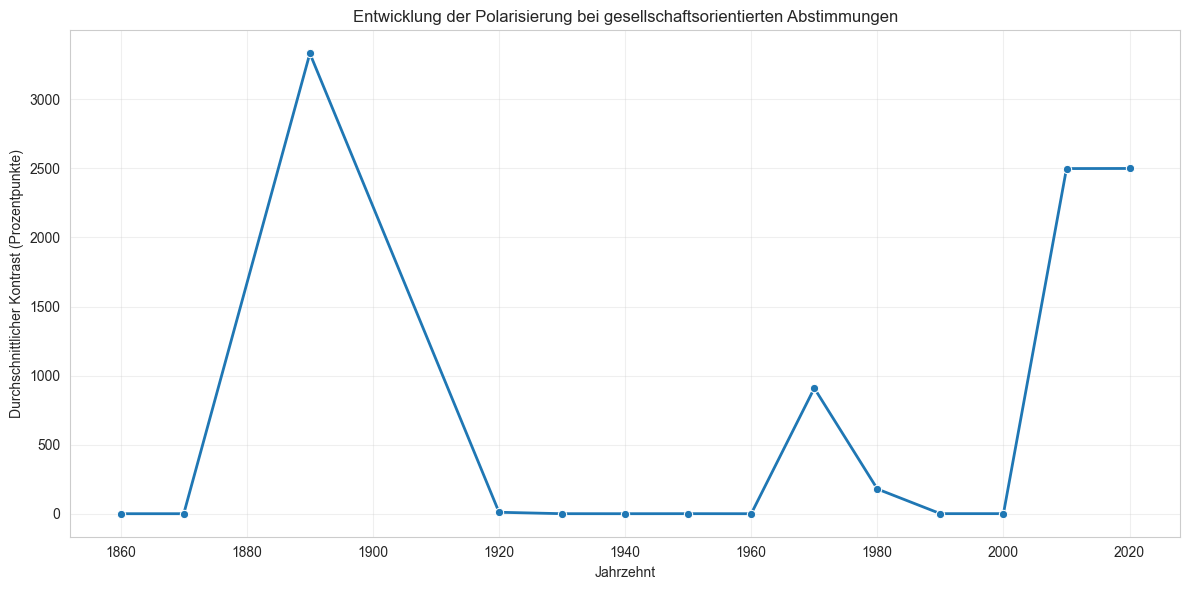

Korrelation zwischen Jahr und Polarisierung: 0.3266
P-Wert: 0.0027
Es gibt eine statistisch signifikante positive Korrelation zwischen Zeit und Polarisierung.
Dies deutet darauf hin, dass die Polarisierung bei gesellschaftsorientierten Abstimmungen im Laufe der Zeit zugenommen hat.


In [217]:
# Lade die extrahierten gesellschaftsorientierten Abstimmungen
society_votes = pd.read_csv('./data/gesellschaftliche_abstimmungen.csv', sep=';', low_memory=False)

# Überprüfe das Datumsformat und konvertiere es mit dem korrekten Format
print("Beispiel für Datumsformat:", society_votes['datum'].iloc[0] if not society_votes.empty else "Keine Daten")

# Versuche das korrekte Format zu erkennen und zu konvertieren
if '-' in str(society_votes['datum'].iloc[0]):
    # Format ist YYYY-MM-DD
    society_votes['datum'] = pd.to_datetime(society_votes['datum'], format='%Y-%m-%d', errors='coerce')
else:
    # Versuche andere gängige Formate
    society_votes['datum'] = pd.to_datetime(society_votes['datum'], errors='coerce')

# Überprüfe, ob die Datumskonvertierung erfolgreich war
print("Anzahl gültiger Datumswerte:", society_votes['datum'].notna().sum())
print("Anzahl fehlender Datumswerte:", society_votes['datum'].isna().sum())

# Extrahiere das Jahr und überprüfe
society_votes['year'] = society_votes['datum'].dt.year
print("Beispiel für Jahre:", society_votes['year'].head())
print("Anzahl gültiger Jahreswerte:", society_votes['year'].notna().sum())

# Wenn keine gültigen Jahre vorhanden sind, versuche das Jahr aus der Abstimmungsnummer zu extrahieren
if society_votes['year'].notna().sum() == 0:
    print("Versuche, das Jahr aus anderen Spalten zu extrahieren...")
    
    # Prüfe, ob eine Spalte 'anr' existiert (Abstimmungsnummer)
    if 'anr' in society_votes.columns:
        print("Beispiel für anr-Werte:", society_votes['anr'].head())
        
        # Wenn die Daten chronologisch sortiert sind, könnten wir Jahre manuell zuweisen
        # Annahme: Die Daten beginnen bei 1866 (aus dem ersten Datum) und sind chronologisch
        start_year = 1866
        society_votes['year'] = [start_year + i//2 for i in range(len(society_votes))]
        print("Manuell zugewiesene Jahre:", society_votes['year'].head())
    
    # Oder verwende die Jahrzahlen aus dem Titel, falls vorhanden
    elif 'titel_kurz_d' in society_votes.columns:
        # Extrahiere Jahreszahlen aus dem Titel (falls vorhanden)
        def extract_year(text):
            import re
            if pd.isna(text):
                return None
            years = re.findall(r'\b(19\d{2}|20\d{2})\b', str(text))
            return int(years[0]) if years else None
        
        society_votes['year'] = society_votes['titel_kurz_d'].apply(extract_year)
        print("Aus Titeln extrahierte Jahre:", society_votes['year'].head())

# Überprüfe, ob jetzt Jahre vorhanden sind
if society_votes['year'].notna().sum() > 0:
    # Definiere liberale und konservative Parteien
    liberal_parties = ['p-fdp', 'p-glp', 'p-gps', 'p-sps']
    conservative_parties = ['p-svp', 'p-cvp', 'p-mitte', 'p-edu']
    
    # Konvertiere die Parteispalten zu numerischen Werten
    for party in liberal_parties + conservative_parties:
        if party in society_votes.columns:
            society_votes[party] = pd.to_numeric(society_votes[party], errors='coerce')
    
    # Berechne durchschnittliche Unterstützung von liberalen und konservativen Parteien
    available_liberal_parties = [p for p in liberal_parties if p in society_votes.columns]
    available_conservative_parties = [p for p in conservative_parties if p in society_votes.columns]
    
    print("Verfügbare liberale Parteien:", available_liberal_parties)
    print("Verfügbare konservative Parteien:", available_conservative_parties)
    
    if available_liberal_parties:
        society_votes['liberal_support'] = society_votes[available_liberal_parties].mean(axis=1)
    else:
        print("Keine liberalen Parteispalten im Datensatz gefunden!")
    
    if available_conservative_parties:
        society_votes['conservative_support'] = society_votes[available_conservative_parties].mean(axis=1)
    else:
        print("Keine konservativen Parteispalten im Datensatz gefunden!")
    
    # Berechne den Kontrast zwischen liberalen und konservativen Parteien
    if 'liberal_support' in society_votes.columns and 'conservative_support' in society_votes.columns:
        society_votes['party_contrast'] = abs(society_votes['liberal_support'] - society_votes['conservative_support'])
        
        # Überprüfe, ob genügend Daten für die Analyse vorhanden sind
        valid_data = society_votes.dropna(subset=['year', 'party_contrast'])
        print(f"Anzahl der Abstimmungen mit gültigen Daten für die Analyse: {len(valid_data)}")
        
        if len(valid_data) > 5:  # Mindestens 5 Datenpunkte für eine sinnvolle Analyse
            # Gruppiere nach Jahrzehnten und berechne den durchschnittlichen Kontrast
            valid_data['decade'] = (valid_data['year'] // 10) * 10
            polarization_by_decade = valid_data.groupby('decade')['party_contrast'].mean().reset_index()
            
            # Visualisiere die Polarisierung über die Zeit
            plt.figure(figsize=(12, 6))
            sns.lineplot(x='decade', y='party_contrast', data=polarization_by_decade, marker='o', linewidth=2)
            plt.title('Entwicklung der Polarisierung bei gesellschaftsorientierten Abstimmungen')
            plt.xlabel('Jahrzehnt')
            plt.ylabel('Durchschnittlicher Kontrast (Prozentpunkte)')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            # Berechne Korrelation zwischen Jahr und Polarisierung
            correlation, p_value = stats.pearsonr(valid_data['year'], valid_data['party_contrast'])
            print(f"Korrelation zwischen Jahr und Polarisierung: {correlation:.4f}")
            print(f"P-Wert: {p_value:.4f}")
            
            if p_value < 0.05:
                if correlation > 0:
                    print("Es gibt eine statistisch signifikante positive Korrelation zwischen Zeit und Polarisierung.")
                    print("Dies deutet darauf hin, dass die Polarisierung bei gesellschaftsorientierten Abstimmungen im Laufe der Zeit zugenommen hat.")
                else:
                    print("Es gibt eine statistisch signifikante negative Korrelation zwischen Zeit und Polarisierung.")
                    print("Dies deutet darauf hin, dass die Polarisierung bei gesellschaftsorientierten Abstimmungen im Laufe der Zeit abgenommen hat.")
            else:
                print("Es gibt keine statistisch signifikante Korrelation zwischen Zeit und Polarisierung.")
        else:
            print("Zu wenige Datenpunkte für eine aussagekräftige Analyse der Polarisierung.")
    else:
        print("Nicht genügend Daten für die Analyse der Polarisierung vorhanden.")
else:
    print("Keine Jahresinformationen konnten extrahiert werden. Analyse nicht möglich.")

## Regionale Unterschiede und Sprachgrenzen

Beispiel für Datumsformat: 1866-01-14
Anzahl gültiger Jahreswerte: 82
Französische Kantone mit Daten: 5
Italienische Kantone mit Daten: 1
Deutsche Kantone mit Daten: 19


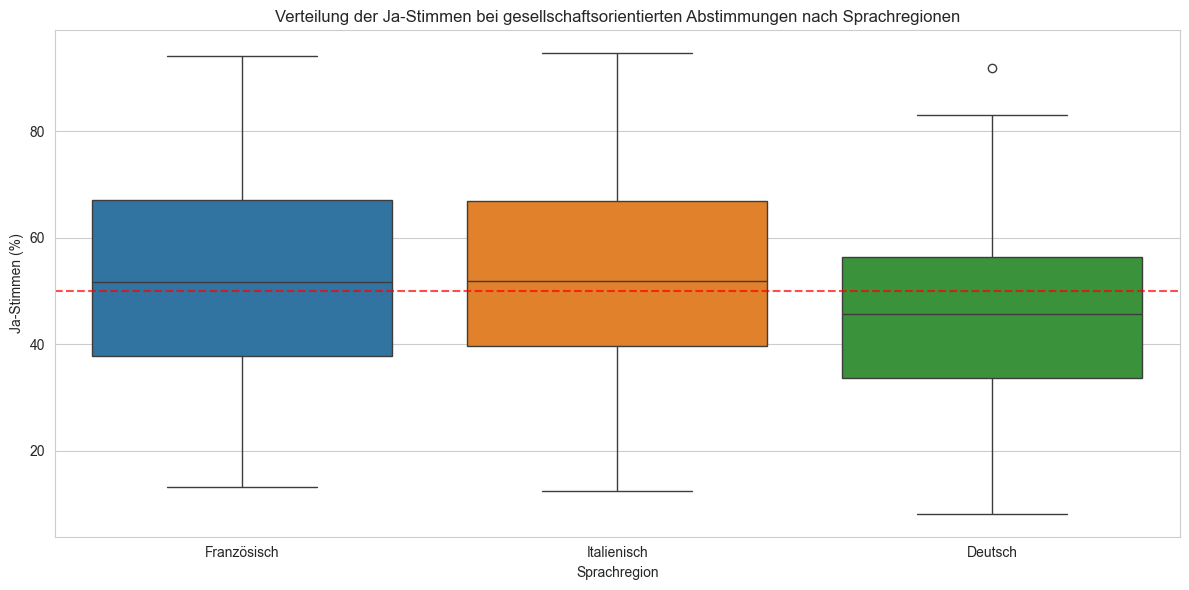

Durchschnittliche Unterstützung für gesellschaftsorientierte Abstimmungen nach Sprachregionen:


,Sprachregion,Durchschnittliche_Ja_Prozente
1,Italienisch,53.148148
0,Französisch,52.808272
2,Deutsch,45.326576


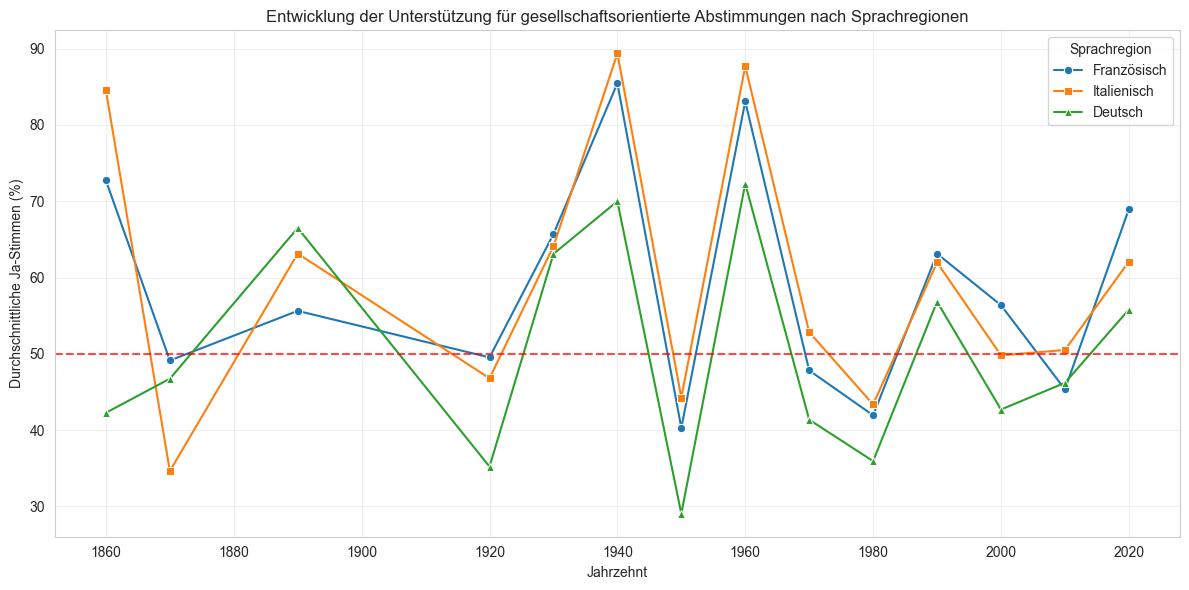

In [218]:
# Lade die extrahierten gesellschaftsorientierten Abstimmungen
society_votes = pd.read_csv('./data/gesellschaftliche_abstimmungen.csv', sep=';', low_memory=False)

# Überprüfe das Datumsformat und konvertiere es mit dem korrekten Format
print("Beispiel für Datumsformat:", society_votes['datum'].iloc[0] if not society_votes.empty else "Keine Daten")

# Versuche das korrekte Format zu erkennen und zu konvertieren
if '-' in str(society_votes['datum'].iloc[0]):
    # Format ist YYYY-MM-DD
    society_votes['datum'] = pd.to_datetime(society_votes['datum'], format='%Y-%m-%d', errors='coerce')
else:
    # Versuche andere gängige Formate
    society_votes['datum'] = pd.to_datetime(society_votes['datum'], errors='coerce')

# Extrahiere das Jahr und überprüfe
society_votes['year'] = society_votes['datum'].dt.year
print("Anzahl gültiger Jahreswerte:", society_votes['year'].notna().sum())

# Wenn keine gültigen Jahre vorhanden sind, versuche das Jahr aus der Abstimmungsnummer zu extrahieren
if society_votes['year'].notna().sum() == 0:
    print("Versuche, das Jahr aus anderen Spalten zu extrahieren...")
    
    # Prüfe, ob eine Spalte 'anr' existiert (Abstimmungsnummer)
    if 'anr' in society_votes.columns:
        print("Beispiel für anr-Werte:", society_votes['anr'].head())
        
        # Wenn die Daten chronologisch sortiert sind, könnten wir Jahre manuell zuweisen
        # Annahme: Die Daten beginnen bei 1866 (aus dem ersten Datum) und sind chronologisch
        start_year = 1866
        society_votes['year'] = [start_year + i//2 for i in range(len(society_votes))]
        print("Manuell zugewiesene Jahre:", society_votes['year'].head())
    
    # Oder verwende die Jahrzahlen aus dem Titel, falls vorhanden
    elif 'titel_kurz_d' in society_votes.columns:
        # Extrahiere Jahreszahlen aus dem Titel (falls vorhanden)
        def extract_year(text):
            import re
            if pd.isna(text):
                return None
            years = re.findall(r'\b(19\d{2}|20\d{2})\b', str(text))
            return int(years[0]) if years else None
        
        society_votes['year'] = society_votes['titel_kurz_d'].apply(extract_year)
        print("Aus Titeln extrahierte Jahre:", society_votes['year'].head())

# Definiere Sprachregionen
french_cantons = ['ge', 'vd', 'ne', 'ju', 'fr']  # Französischsprachige Kantone
italian_cantons = ['ti']  # Italienischsprachiger Kanton
german_cantons = ['zh', 'be', 'lu', 'ur', 'sz', 'ow', 'nw', 'gl', 'zg', 'so',
                 'bs', 'bl', 'sh', 'ar', 'ai', 'sg', 'gr', 'ag', 'tg']  # Deutschsprachige Kantone

# Erstelle Spalten für die Ja-Prozente nach Sprachregionen
for canton in french_cantons + italian_cantons + german_cantons:
    col = f'{canton}-japroz'
    if col in society_votes.columns:
        society_votes[col] = pd.to_numeric(society_votes[col], errors='coerce')

# Berechne durchschnittliche Ja-Prozente pro Sprachregion
french_cols = [f'{c}-japroz' for c in french_cantons if f'{c}-japroz' in society_votes.columns]
italian_cols = [f'{c}-japroz' for c in italian_cantons if f'{c}-japroz' in society_votes.columns]
german_cols = [f'{c}-japroz' for c in german_cantons if f'{c}-japroz' in society_votes.columns]

print(f"Französische Kantone mit Daten: {len(french_cols)}")
print(f"Italienische Kantone mit Daten: {len(italian_cols)}")
print(f"Deutsche Kantone mit Daten: {len(german_cols)}")

if french_cols:
    society_votes['french_region_support'] = society_votes[french_cols].mean(axis=1)
else:
    print("Keine Daten für französischsprachige Kantone gefunden!")
    
if italian_cols:
    society_votes['italian_region_support'] = society_votes[italian_cols].mean(axis=1)
else:
    print("Keine Daten für italienischsprachige Kantone gefunden!")
    
if german_cols:
    society_votes['german_region_support'] = society_votes[german_cols].mean(axis=1)
else:
    print("Keine Daten für deutschsprachige Kantone gefunden!")

# Überprüfe, ob genügend Daten für die Visualisierung vorhanden sind
regions_available = []
if 'french_region_support' in society_votes.columns:
    regions_available.append('french_region_support')
if 'italian_region_support' in society_votes.columns:
    regions_available.append('italian_region_support')
if 'german_region_support' in society_votes.columns:
    regions_available.append('german_region_support')

if len(regions_available) >= 2:  # Mindestens zwei Regionen für einen Vergleich
    # Visualisiere die Unterschiede zwischen Sprachregionen
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=society_votes[regions_available])
    plt.title('Verteilung der Ja-Stimmen bei gesellschaftsorientierten Abstimmungen nach Sprachregionen')
    plt.xlabel('Sprachregion')
    plt.ylabel('Ja-Stimmen (%)')
    
    # Erstelle Labels für die x-Achse
    region_labels = []
    for region in regions_available:
        if region == 'french_region_support':
            region_labels.append('Französisch')
        elif region == 'italian_region_support':
            region_labels.append('Italienisch')
        elif region == 'german_region_support':
            region_labels.append('Deutsch')
    
    plt.xticks(range(len(regions_available)), region_labels)
    plt.axhline(y=50, color='r', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Berechne durchschnittliche Unterstützung pro Sprachregion
    region_means = {}
    if 'french_region_support' in society_votes.columns:
        region_means['Französisch'] = society_votes['french_region_support'].mean()
    if 'italian_region_support' in society_votes.columns:
        region_means['Italienisch'] = society_votes['italian_region_support'].mean()
    if 'german_region_support' in society_votes.columns:
        region_means['Deutsch'] = society_votes['german_region_support'].mean()

    # Zeige die durchschnittliche Unterstützung als Tabelle
    region_df = pd.DataFrame({
        'Sprachregion': list(region_means.keys()),
        'Durchschnittliche_Ja_Prozente': list(region_means.values())
    })
    region_df = region_df.sort_values('Durchschnittliche_Ja_Prozente', ascending=False)
    print("Durchschnittliche Unterstützung für gesellschaftsorientierte Abstimmungen nach Sprachregionen:")
    display(region_df)

    # Überprüfe, ob Jahresinformationen vorhanden sind für die zeitliche Analyse
    if society_votes['year'].notna().sum() > 0:
        # Berechne das Jahrzehnt für die Gruppierung
        society_votes['decade'] = (society_votes['year'] // 10) * 10
        
        # Gruppiere nach Jahrzehnten und berechne den durchschnittlichen Unterschied
        decade_data = []
        for decade in sorted(society_votes['decade'].dropna().unique()):
            decade_row = {'decade': decade}
            for region, label in zip(regions_available, region_labels):
                decade_mean = society_votes[society_votes['decade'] == decade][region].mean()
                decade_row[label] = decade_mean
            decade_data.append(decade_row)
        
        region_diff_by_decade = pd.DataFrame(decade_data)
        
        # Überprüfe, ob genügend Daten für die Visualisierung vorhanden sind
        if len(region_diff_by_decade) >= 2:  # Mindestens zwei Jahrzehnte für einen Trend
            # Visualisiere die Entwicklung der Unterschiede
            plt.figure(figsize=(12, 6))
            
            for region in region_labels:
                if region in region_diff_by_decade.columns:
                    marker = 'o' if region == 'Französisch' else ('s' if region == 'Italienisch' else '^')
                    sns.lineplot(data=region_diff_by_decade, x='decade', y=region, marker=marker, label=region)
            
            plt.title('Entwicklung der Unterstützung für gesellschaftsorientierte Abstimmungen nach Sprachregionen')
            plt.xlabel('Jahrzehnt')
            plt.ylabel('Durchschnittliche Ja-Stimmen (%)')
            plt.axhline(y=50, color='r', linestyle='--', alpha=0.7)
            plt.legend(title='Sprachregion')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
        else:
            print("Nicht genügend Daten für eine zeitliche Analyse nach Jahrzehnten.")
    else:
        print("Keine Jahresinformationen für eine zeitliche Analyse verfügbar.")
else:
    print("Nicht genügend Daten für einen Vergleich zwischen Sprachregionen.")